#**Import Library**

In [ ]:
pip install tensorflowjs

In [1]:
# Part 1: Import Libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from collections import defaultdict

In [2]:
print("\u2022 Using TensorFlow Version:", tf.__version__)
print("\u2022 Using TensorFlow Hub Version: ", hub.__version__)
print('\u2022 GPU Device Found.' if tf.config.list_physical_devices('GPU') else '\u2022 GPU Device Not Found. Running on CPU')

• Using TensorFlow Version: 2.17.1
• Using TensorFlow Hub Version:  0.16.1
• GPU Device Not Found. Running on CPU


# **Load Dataset**

### Load from Google Drive

In [3]:
from google.colab import drive

drive.mount('/content/drive', force_remount=True)
data_dir = '/content/drive/MyDrive/dataset 3 ast'

Mounted at /content/drive


In [4]:
label_counts = defaultdict(int)

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    if os.path.isdir(label_path):
        # Hitung jumlah file dalam subfolder yang merupakan label
        label_counts[label] = len(os.listdir(label_path))

for label, count in label_counts.items():
    print(f"Label: {label}, Jumlah data: {count}")

Label: Bruises, Jumlah data: 131
Label: Burns, Jumlah data: 127
Label: Cut, Jumlah data: 118
Label: Abrasions, Jumlah data: 120
Label: Normal, Jumlah data: 130


### Display data label

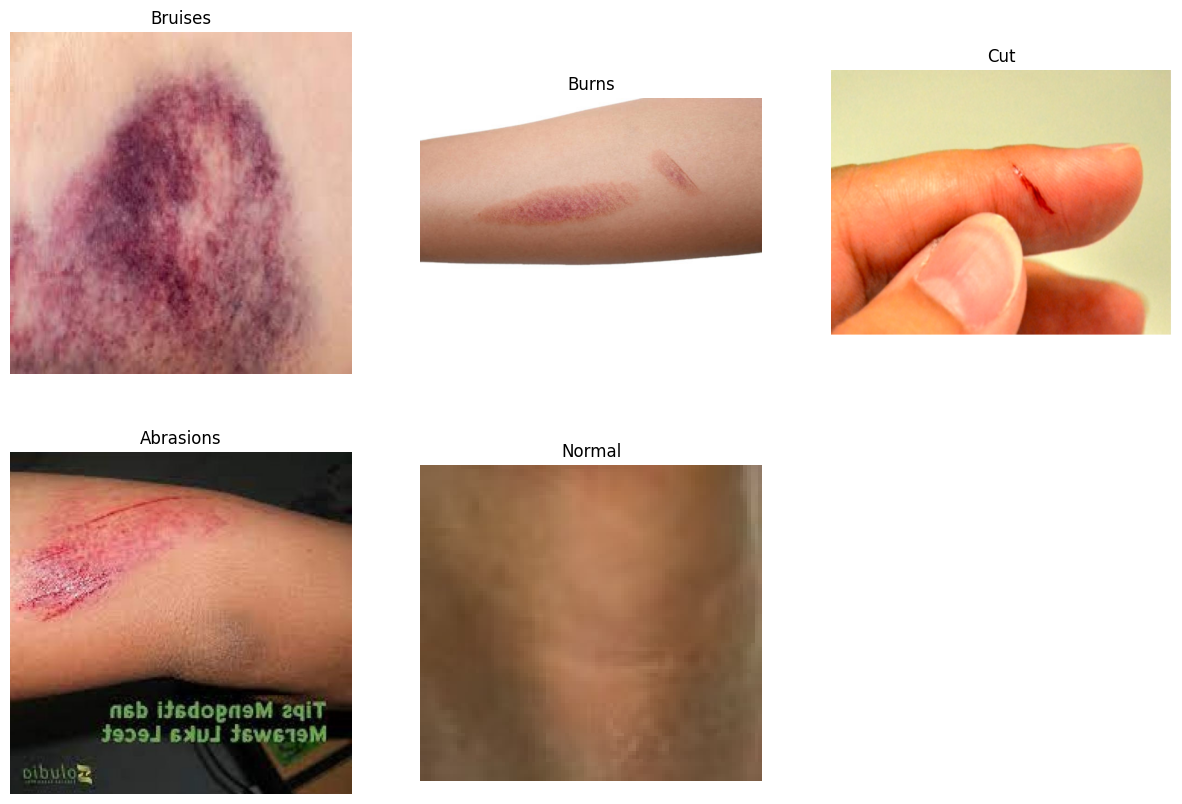

In [5]:
# Display Example Images for Each Label
categories = os.listdir(data_dir)
plt.figure(figsize=(15, 10))

for i, category in enumerate(categories):
    folder_path = os.path.join(data_dir, category)
    first_image = os.listdir(folder_path)[0]
    img_path = os.path.join(folder_path, first_image)
    img = plt.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")

plt.show()

# **Preprocess Images and Prepare Data**

Set batch dan image size

In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32

In [7]:
# Get list of image paths and labels
image_paths = []
labels = []

for label in os.listdir(data_dir):
    label_path = os.path.join(data_dir, label)
    for img_file in os.listdir(label_path):
        image_paths.append(os.path.join(label_path, img_file))
        labels.append(label)

Spliting data (80:10:10)

In [8]:
# Split data into training (80%) and temp (20%)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Further split temp into validation (10%) and test (10%)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
)

print(f"Total training images: {len(train_paths)}")
print(f"Total validation images: {len(val_paths)}")
print(f"Total test images: {len(test_paths)}")

Total training images: 500
Total validation images: 63
Total test images: 63


Prepocessing (normalize data) & shuffle batch

In [9]:
def create_generator(image_paths, labels, image_size, batch_size):
    label_map = {label: idx for idx, label in enumerate(set(labels))}
    num_classes = len(label_map)

    # normalization
    datagen = ImageDataGenerator(rescale=1./255)

    # Create generator from the given images and labels
    generator = datagen.flow_from_dataframe(
        dataframe=pd.DataFrame({'filename': image_paths, 'class': labels}),
        x_col='filename',
        y_col='class',
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        classes=label_map,
        shuffle=True
    )
    return generator

train_generator = create_generator(train_paths, train_labels, IMAGE_SIZE, BATCH_SIZE)
validation_generator = create_generator(val_paths, val_labels, IMAGE_SIZE, BATCH_SIZE)
test_generator = create_generator(test_paths, test_labels, IMAGE_SIZE, BATCH_SIZE)

Found 500 validated image filenames belonging to 5 classes.
Found 63 validated image filenames belonging to 5 classes.
Found 63 validated image filenames belonging to 5 classes.


# **Transfer Learning**

### Import base model

In [10]:
# Part 5: Transfer Learning with MobileNetV2 Base Model
base_model = tf.keras.applications.MobileNetV2(input_shape=(224, 224, 3),
                                               include_top=False,
                                               weights='imagenet')

# Freeze base model layers
base_model.trainable = False

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### Custom layer model

In [11]:
# Custom top layers
# model = models.Sequential([
#     base_model,
#     layers.GlobalAveragePooling2D(),
#     layers.Dense(1024, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(len(categories), activation='softmax')
# ])

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(categories), activation='softmax')
])

### Training model

In [12]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
# Part 6: Train the Model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


16/16 ━━━━━━━━━━━━━━━━━━━━ 144s 6s/step - accuracy: 0.4081 - loss: 1.7941 - val_accuracy: 0.8413 - val_loss: 0.5054
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step - accuracy: 0.7950 - loss: 0.4739 - val_accuracy: 0.8571 - val_loss: 0.3879
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8756 - loss: 0.3069 - val_accuracy: 0.8730 - val_loss: 0.3368
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9377 - loss: 0.1968 - val_accuracy: 0.8889 - val_loss: 0.3273
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.9313 - loss: 0.1663 - val_accuracy: 0.8730 - val_loss: 0.3659
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9749 - loss: 0.0801 - val_accuracy: 0.9048 - val_loss: 0.2618
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 46s 3s/step - accuracy: 0.9884 - loss: 0.0786 - val_accuracy: 0.8730 - val_loss: 0.3281
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.9736 - loss: 0.0849 - val_accuracy: 0.8889 - val_loss: 0.3928
Ep

### Visualize Results

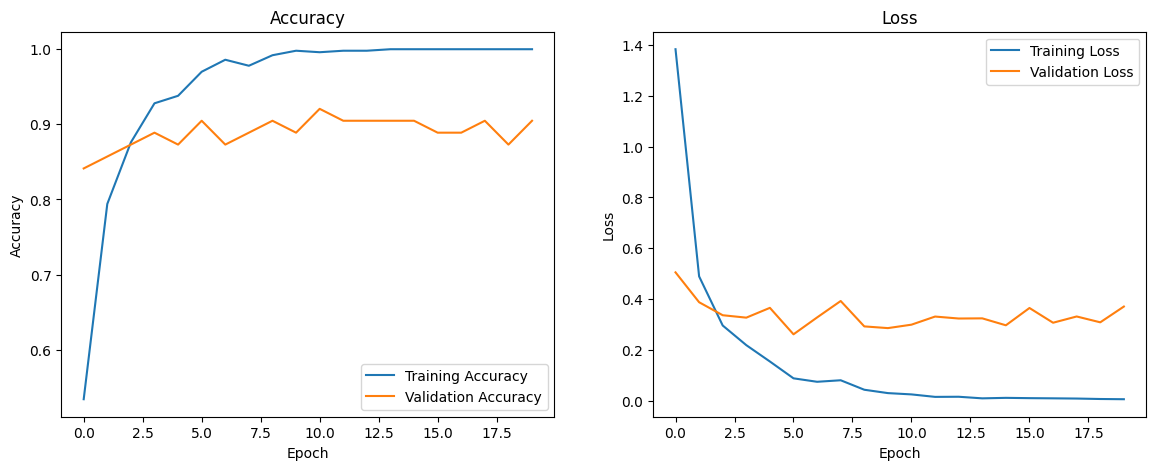

In [14]:
# Part 7: Visualize Training Results
plt.figure(figsize=(14, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

# **Testing Model**

### Accuracy

In [20]:
# Part 8: Evaluate Model on Test Data
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 1s/step - accuracy: 0.8947 - loss: 0.4530

Test Accuracy: 0.8889
Test Loss: 0.5005


### Test upload file

In [22]:
from tensorflow.keras.preprocessing import image
from google.colab import files
import numpy as np

# Upload multiple images manually
uploaded = files.upload()

for img_path in uploaded.keys():
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=IMAGE_SIZE)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Normalize image

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = np.argmax(prediction, axis=1)[0]

    # Retrieve class label
    class_labels = list(train_generator.class_indices.keys())
    predicted_label = class_labels[predicted_class]

    # Display the result
    plt.figure()
    plt.imshow(img)
    plt.title(f"Predicted Label: {predicted_label}")
    plt.axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# **Convert Model**

### .h5

In [ ]:
# Save the model in .h5 format
model.save('wounds_model.h5')
print("Model has been saved as 'wounds_model.h5'")

Model has been saved as 'wounds_model.h5'


In [ ]:
# Save the model in native Keras format (.keras)
model.save('wounds_model.keras')
print("Model has been saved as 'wounds_model.keras'")

Model has been saved as 'wounds_model.keras'


### Tf.js

In [ ]:
import subprocess

# Convert the .h5 model to TensorFlow.js format
subprocess.run([
    "tensorflowjs_converter",
    "--input_format", "keras",
    "--output_format", "tfjs_layers_model",
    "burns_model.h5",
    "tfjs_model"
])

print("Model has been converted to TensorFlow.js format and saved in 'tfjs_model' directory.")

Model has been converted to TensorFlow.js format and saved in 'tfjs_model' directory.


### TFlite

In [ ]:
import tensorflow as tf

# Define the input and output file names
keras_model_file = "wounds_model.keras"  # Input model in .keras format
tflite_model_file = "wounds_model.tflite"  # Output TFLite model

# Load the Keras model
model = tf.keras.models.load_model(keras_model_file)

# Initialize the TFLite converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Optional: Apply optimization for smaller model size (e.g., quantization)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model to TFLite format
tflite_model = converter.convert()

# Save the TFLite model to a file
with open(tflite_model_file, "wb") as f:
    f.write(tflite_model)

print(f"Model has been converted to TensorFlow Lite format and saved as '{tflite_model_file}'")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Saved artifact at '/tmp/tmpt93xg6qs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  132687291217728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291228304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291230416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291223728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291226016: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291235520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291305120: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291305824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291301952: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132687291302832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1326872913082

# add

In [ ]:
# # Plot model graph
# plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')